In [1]:
# Rodrigo Caye Daudt
# rodrigo.cayedaudt@geod.baug.ethz.ch
# 03/2021

%matplotlib inline
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

%load_ext autoreload
%autoreload 2

if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

In [2]:
# Read images and labels

# Sentinel band names
band_names = [
    'band2', 
    'band3', 
    'band4', 
    'band5', 
    'band6', 
    'band7', 
    'band8', 
    'band8a', 
    'band11', 
    'band12', 
]

# Band wavelengths in nm
wavelengths = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]

# Load images
img_dict = {}
for bn in band_names:
    img_dict[bn] = io.imread(f'../raw_data/sentinel2_{bn}.tif')


# Class labels
labels = io.imread('labels.tif')

# Class masks
classes_dict = {
    'forest': 1,
    'water': 2,
    'clouds': 3,
    'fields (green)': 4,
    'fields (brown)': 5,
    'cities': 6,
    'snow': 7,
    'rock': 8,
}

# Extract class masks from labels
masks_dict = {}
min_np = np.inf # minimum number of pixels in a class
for class_name in classes_dict.keys():
    masks_dict[class_name] = labels == classes_dict[class_name]
    print(f'Number of pixels in class "{class_name}": {masks_dict[class_name].sum()}')
    min_np = min(min_np, masks_dict[class_name].sum())

if min_np < 100:
    print('WARNING: at least one of the classes contain very few examples (<100 pixels).')


Number of pixels in class "forest": 11722
Number of pixels in class "water": 148204
Number of pixels in class "clouds": 83733
Number of pixels in class "fields (green)": 5188
Number of pixels in class "fields (brown)": 1130
Number of pixels in class "cities": 47144
Number of pixels in class "snow": 104004
Number of pixels in class "rock": 82132


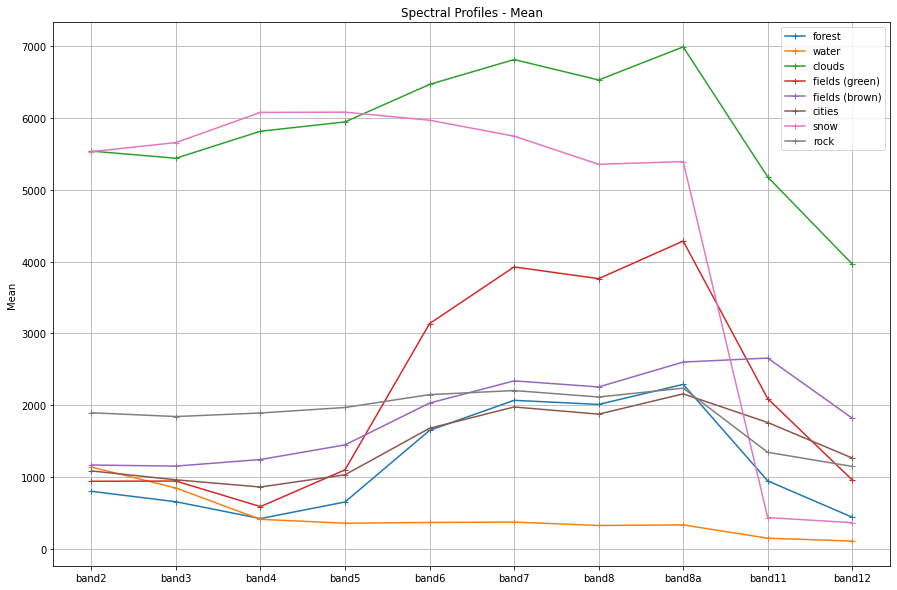

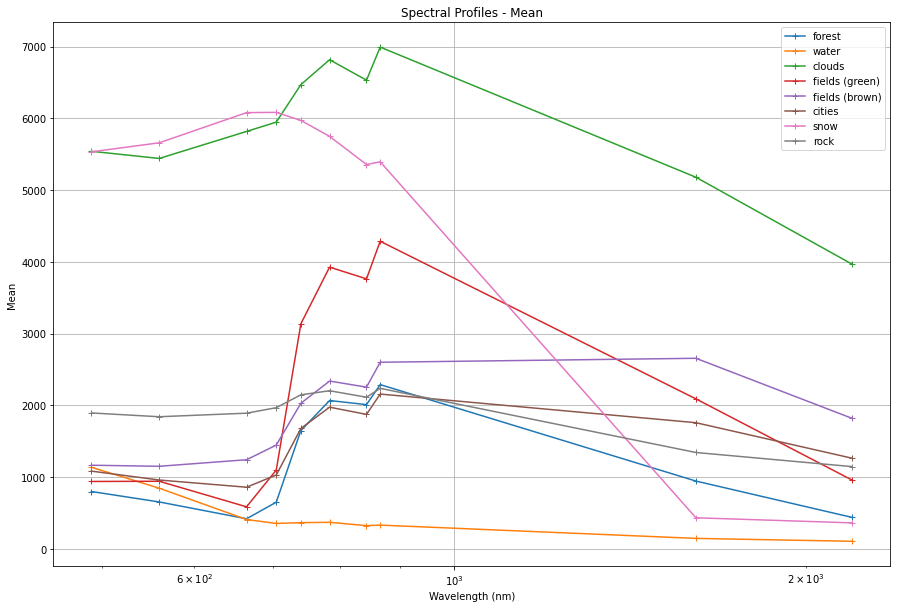

In [3]:
# Calculate and plot spectral profiles - Mean

# Calculate the mean of each class in each band
mean_dict = {}
for class_name in classes_dict.keys():
    spectral_profile = []
    for band in band_names:
        # TODO: calculate the mean for pixels in class "class_name" and band "band"
        spectral_profile.append(np.mean(img_dict[band][masks_dict[class_name]]))
    mean_dict[class_name] = spectral_profile

# Plot using band index as X
plt.figure(figsize=[15, 10])
plt.grid()
for class_name in classes_dict.keys():
    plt.plot(np.arange(len(band_names)), mean_dict[class_name], marker='+', label=class_name)
plt.legend()
plt.title('Spectral Profiles - Mean')
plt.xticks(np.arange(len(band_names)), band_names)
plt.ylabel('Mean')
plt.savefig('outputs/01-01_mean-profiles_band.pdf')

# Plot band wavelength as X
plt.figure(figsize=[15, 10])
plt.grid()
for class_name in classes_dict.keys():
    plt.semilogx(wavelengths, mean_dict[class_name], marker='+', label=class_name)
plt.legend()
plt.title('Spectral Profiles - Mean')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Mean')
plt.savefig('outputs/01-02_mean-profiles_wavelength.pdf')

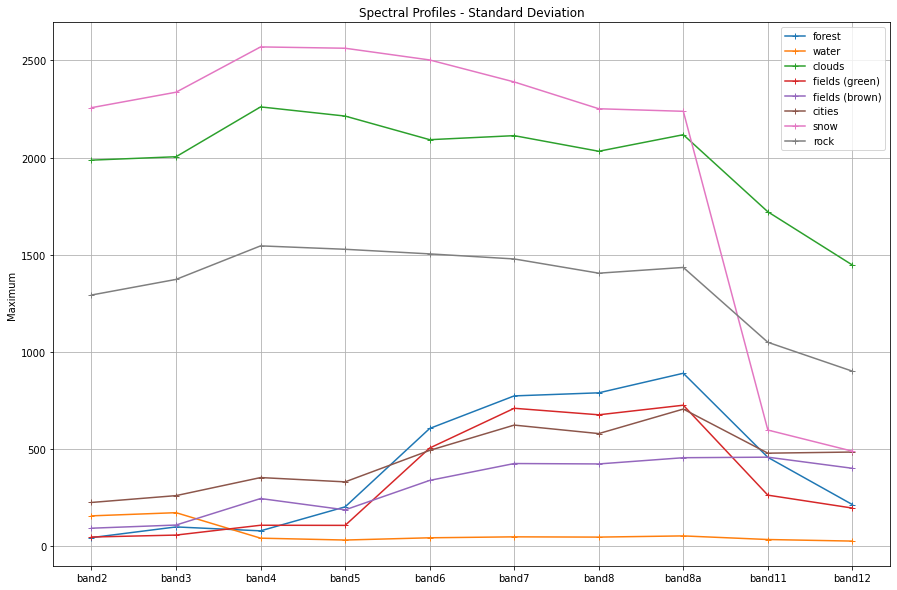

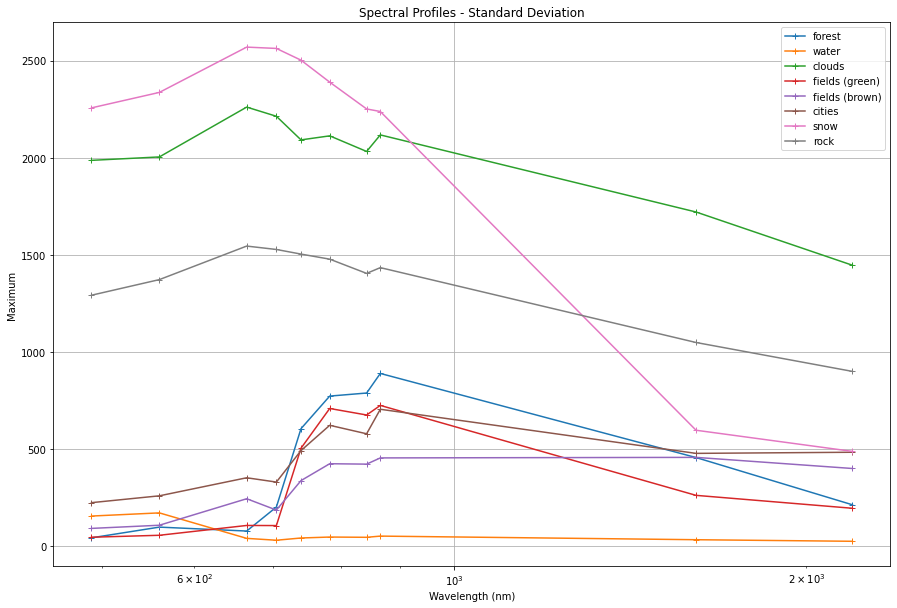

In [4]:
# Calculate and plot spectral profiles - Standard deviation

# Calculate the maximum of each class in each band
std_dict = {}
for class_name in classes_dict.keys():
    spectral_profile = []
    for band in band_names:
        # TODO: calculate the standard deviation for pixels in class "class_name" and band "band"
        spectral_profile.append(np.std(img_dict[band][masks_dict[class_name]]))
    std_dict[class_name] = spectral_profile

# Plot using band index as X
plt.figure(figsize=[15, 10])
plt.grid()
for class_name in classes_dict.keys():
    plt.plot(np.arange(len(band_names)), std_dict[class_name], marker='+', label=class_name)
plt.legend()
plt.title('Spectral Profiles - Standard Deviation')
plt.xticks(np.arange(len(band_names)), band_names)
plt.ylabel('Maximum')
plt.savefig('outputs/02-01_std-profiles_band.pdf')

# Plot band wavelength as X
plt.figure(figsize=[15, 10])
plt.grid()
for class_name in classes_dict.keys():
    plt.semilogx(wavelengths, std_dict[class_name], marker='+', label=class_name)
plt.legend()
plt.title('Spectral Profiles - Standard Deviation')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Maximum')
plt.savefig('outputs/02-02_std-profiles_wavelength.pdf')

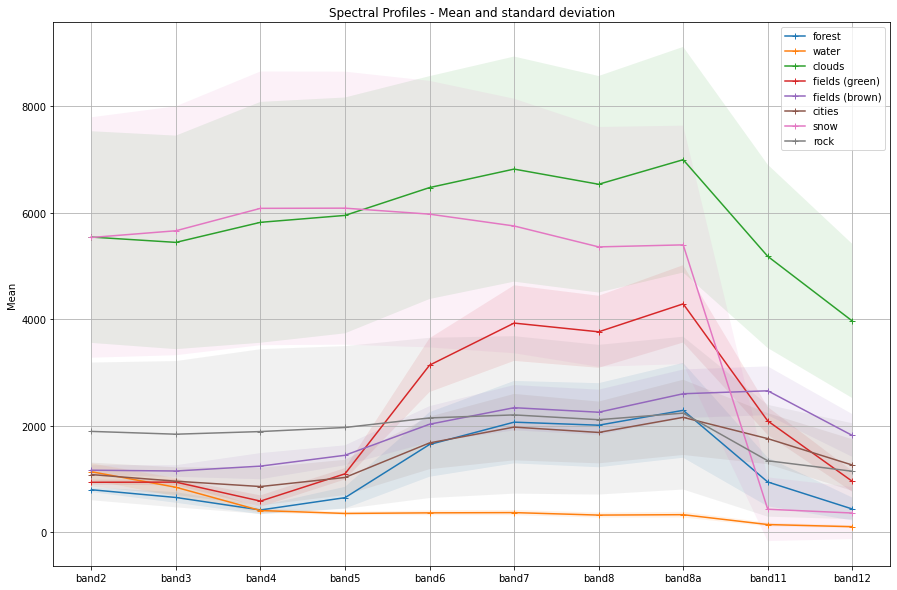

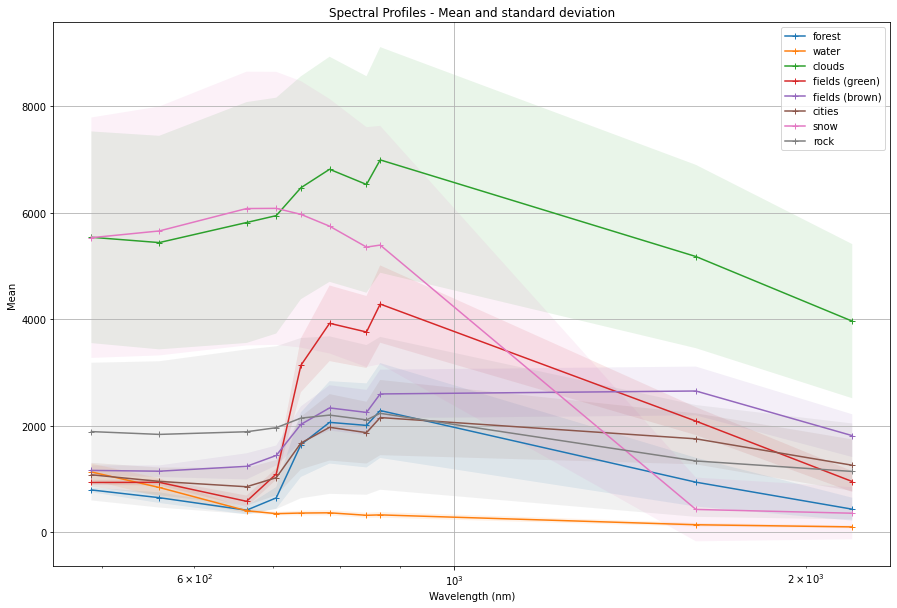

In [5]:
# Calculate and plot spectral profiles - Mean and standard deviation

# Plot using band as X
plt.figure(figsize=[15, 10])
plt.grid()
for class_name in classes_dict.keys():
    plt.plot(np.arange(len(band_names)), mean_dict[class_name], marker='+', label=class_name)
    plt.fill_between(np.arange(len(band_names)), np.array(mean_dict[class_name]) - np.array(std_dict[class_name]), np.array(mean_dict[class_name]) + np.array(std_dict[class_name]), alpha=0.1)
plt.legend()
plt.title('Spectral Profiles - Mean and standard deviation')
plt.xticks(np.arange(len(band_names)), band_names)
plt.ylabel('Mean')
plt.savefig('outputs/03-01_mean-and-std-profiles_band.pdf')

# Plot using band index as X
plt.figure(figsize=[15, 10])
plt.grid()
for class_name in classes_dict.keys():
    plt.semilogx(wavelengths, mean_dict[class_name], marker='+', label=class_name)
    plt.fill_between(wavelengths, np.array(mean_dict[class_name]) - np.array(std_dict[class_name]), np.array(mean_dict[class_name]) + np.array(std_dict[class_name]), alpha=0.1)
plt.legend()
plt.title('Spectral Profiles - Mean and standard deviation')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Mean')
plt.savefig('outputs/03-02_mean-and-std-profiles_wavelength.pdf')

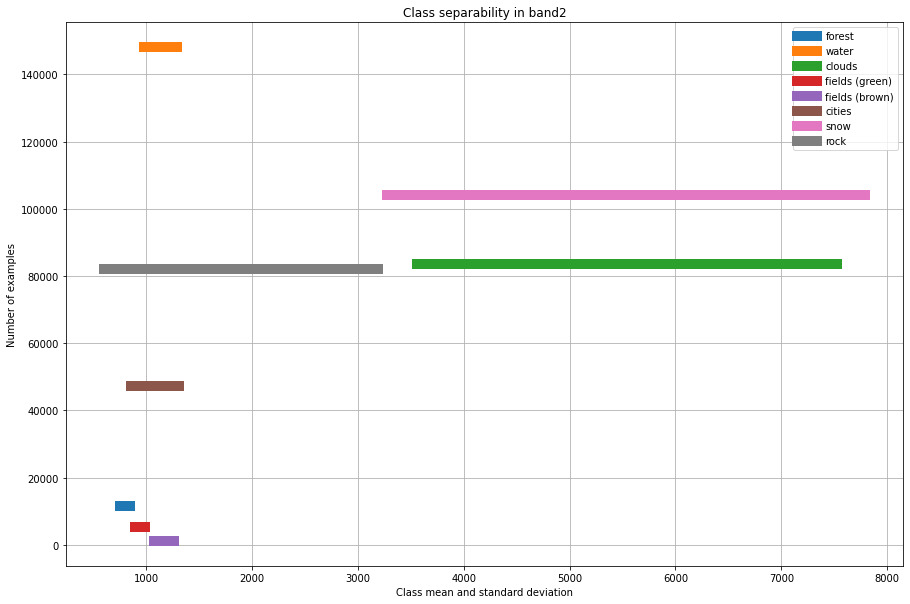

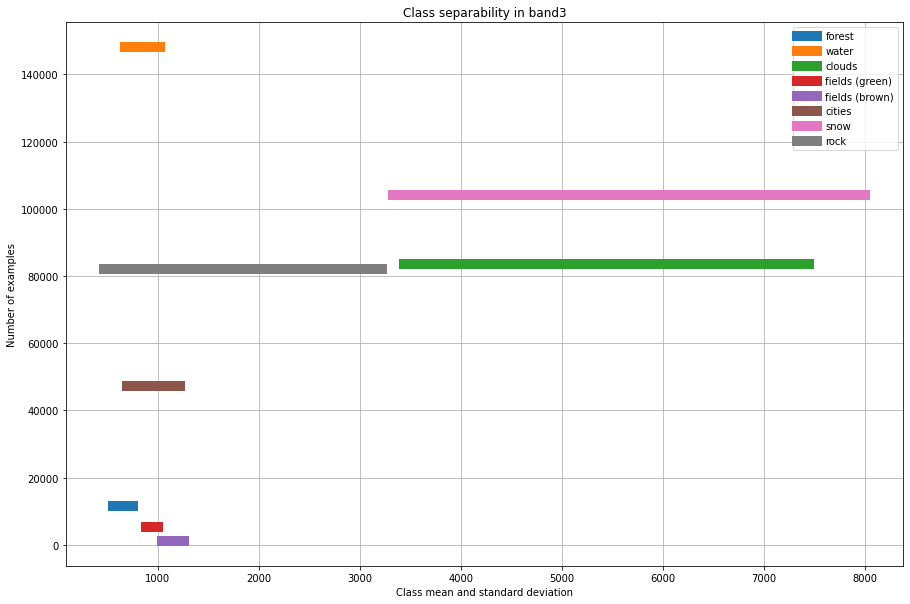

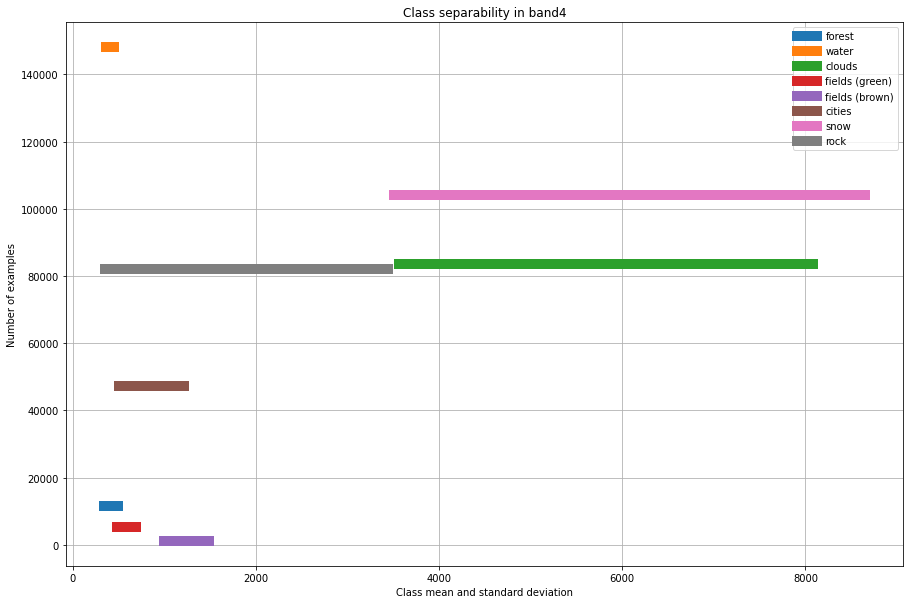

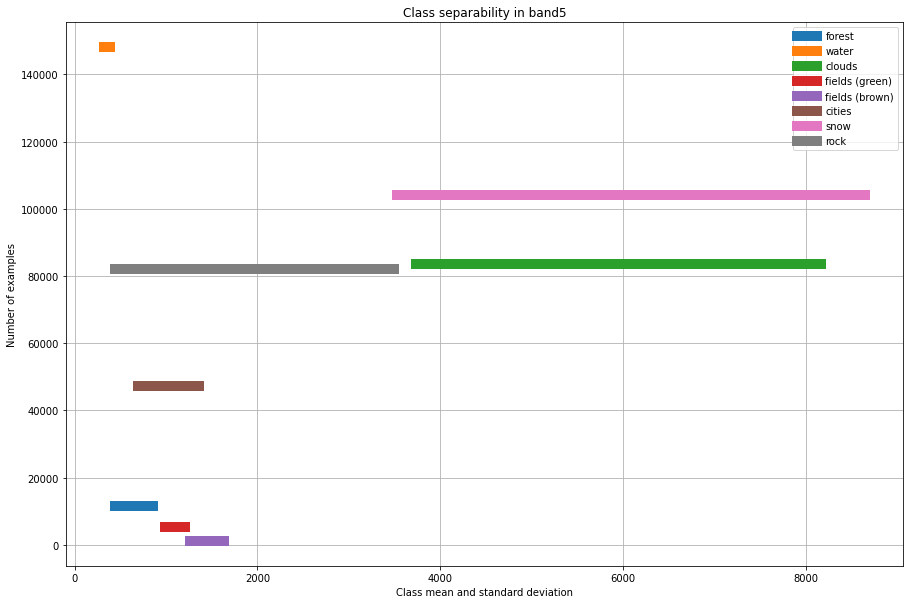

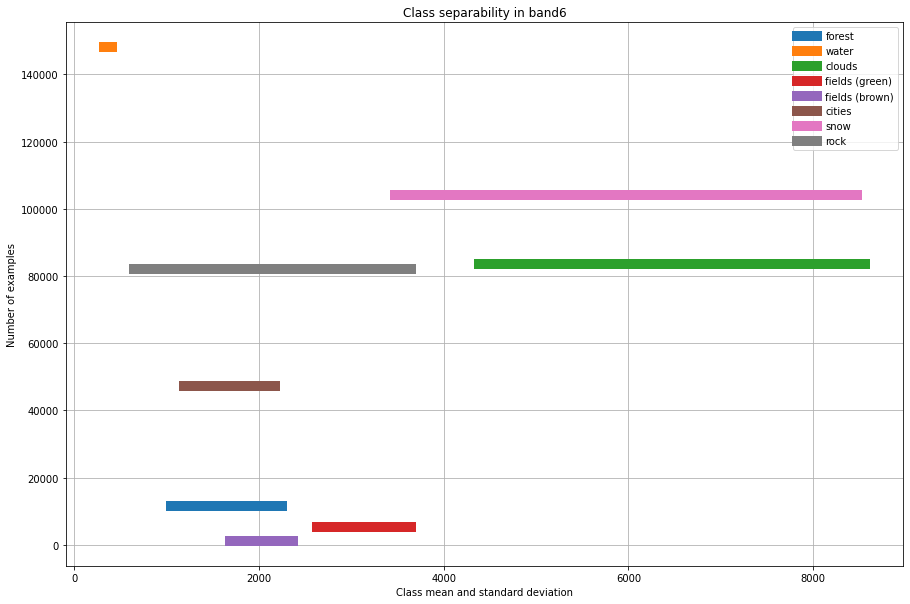

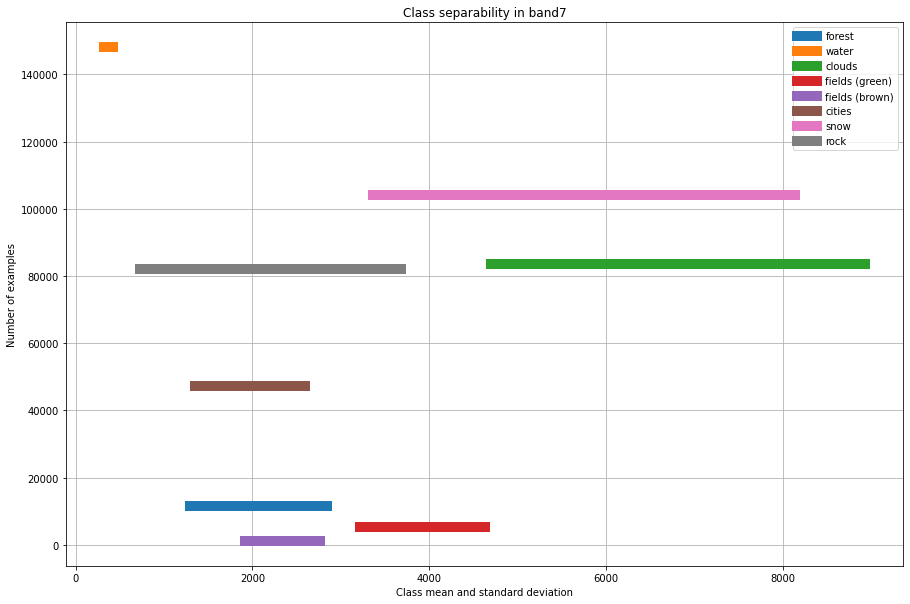

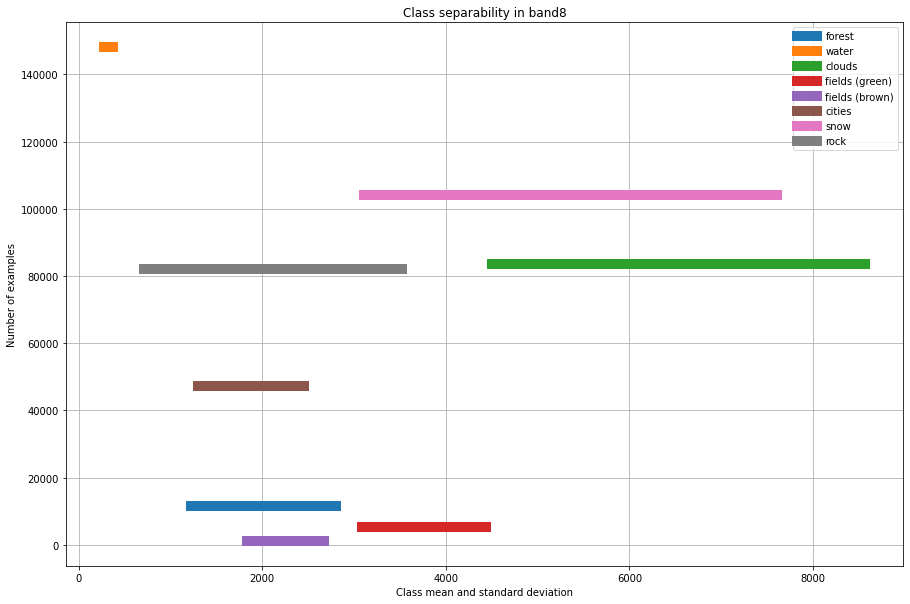

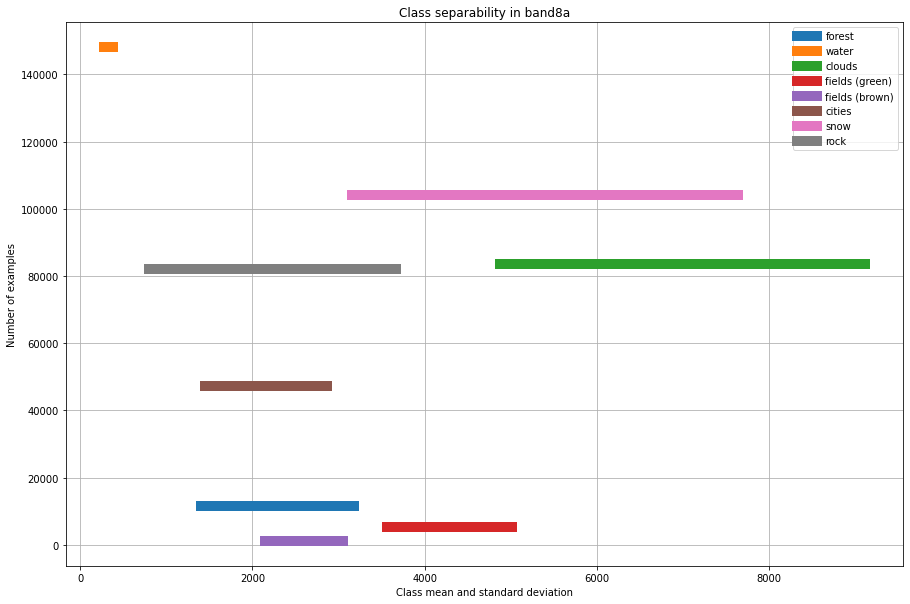

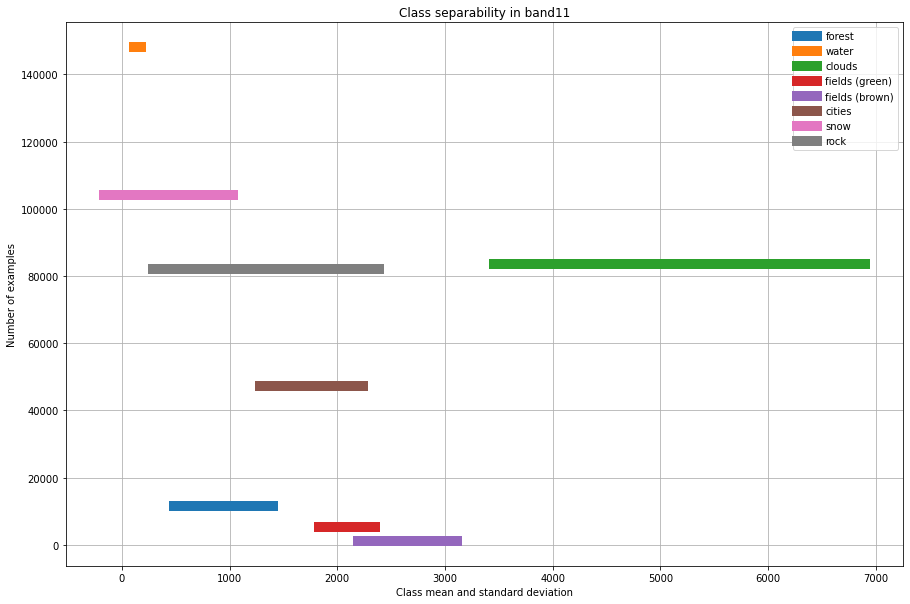

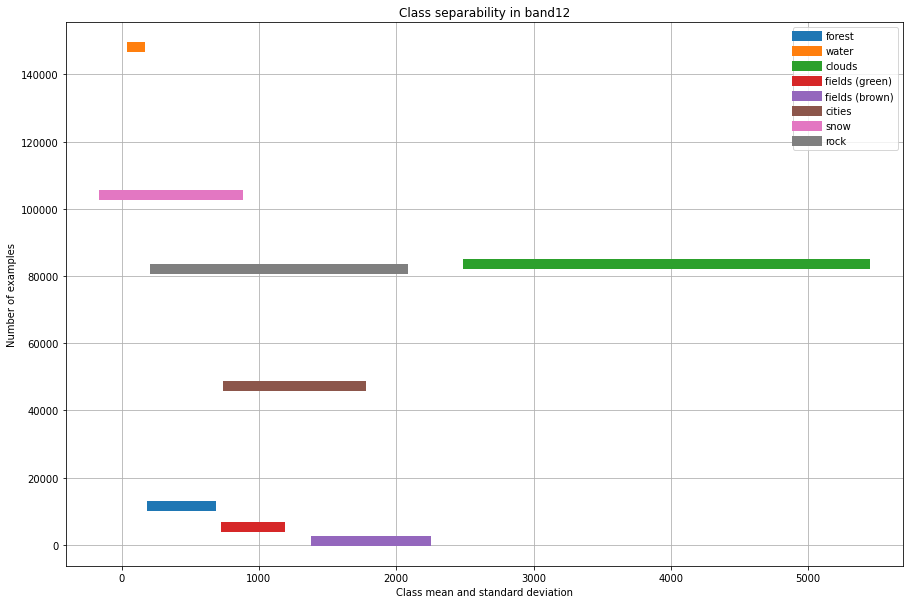

In [6]:
# Visualize class separability

# Calculate the total number of examples in each class in each band
total_dict = {}
for class_name in classes_dict.keys():
    spectral_profile = []
    for band in band_names:
        # TODO: calculate the number of labelled pixels in class "class_name"
        spectral_profile.append(np.sum(masks_dict[class_name]))
    total_dict[class_name] = spectral_profile

for i, band in enumerate(band_names):
    plt.figure(figsize=[15, 10])
    plt.grid()
    for j, class_name in enumerate(classes_dict.keys()):
        x, std = mean_dict[class_name][i], std_dict[class_name][i]
        x = [x - std, x, x + std]
        y = total_dict[class_name][i]
        y = [y, y, y]
        plt.plot(x, y, label=class_name, lw=10)
    plt.legend()
    plt.title(f'Class separability in {band}')
    plt.xlabel('Class mean and standard deviation')
    plt.ylabel('Number of examples')
    plt.savefig(f'outputs/04-0{i}_separability-in-{band}.pdf')


In [7]:
# Scatter plots using two bands


# TODO: use different class combinations to visualize in what bands classes are or are not separable
# Tip: all possible band names can be found in the variable band_names

def visualiza_bands(band_x, band_y):
    N = min_np # points per class
    plt.figure(figsize=[15, 10])
    plt.grid()
    for class_name in classes_dict.keys():
        x = img_dict[band_x][masks_dict[class_name]]
        y = img_dict[band_y][masks_dict[class_name]]
        indices = np.random.choice(np.arange(len(x)), N, replace=False)
        x = x[indices]
        y = y[indices]
        plt.scatter(x, y, marker='.', label=class_name, alpha=0.2)
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.title(f'Pixel Brightness in Bands "{band_x}" and "{band_y}"')
    plt.xlabel(f'Brightness in band "{band_x}"')
    plt.ylabel(f'Brightness in band "{band_y}"')
    plt.savefig(f'outputs/05-01_scatter-{band_x}-{band_y}.pdf')


    fig = plt.figure(figsize=[15, 10])
    ax = fig.add_subplot()
    plt.grid()
    for class_name in classes_dict.keys():
        x = img_dict[band_x][masks_dict[class_name]]
        y = img_dict[band_y][masks_dict[class_name]]
        cov = np.cov(x, y)
        indices = np.random.choice(np.arange(len(x)), N, replace=False)
        x = x[indices]
        y = y[indices]
        p = plt.scatter(x, y, marker='.', label=class_name, alpha=0.05)

        # Adapted from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                facecolor=p.get_facecolor().squeeze(), edgecolor=p.get_facecolor().squeeze()[:3])

        # Number of standard deviations
        n_std = 2.0

        # Calculating the stdandard deviation of x from
        # the square root of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = np.mean(x)

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = np.mean(y)

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)

        ax.add_patch(ellipse)
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.title(f'Pixel Brightness in Bands "{band_x}" and "{band_y}"')
    plt.xlabel(f'Brightness in band "{band_x}"')
    plt.ylabel(f'Brightness in band "{band_y}"')
    plt.savefig(f'outputs/05-02_scatter-{band_x}-{band_y}_ellipses.pdf')

band3 band8a
band4 band7
band5 band8a
band8a band12
band8 band8a


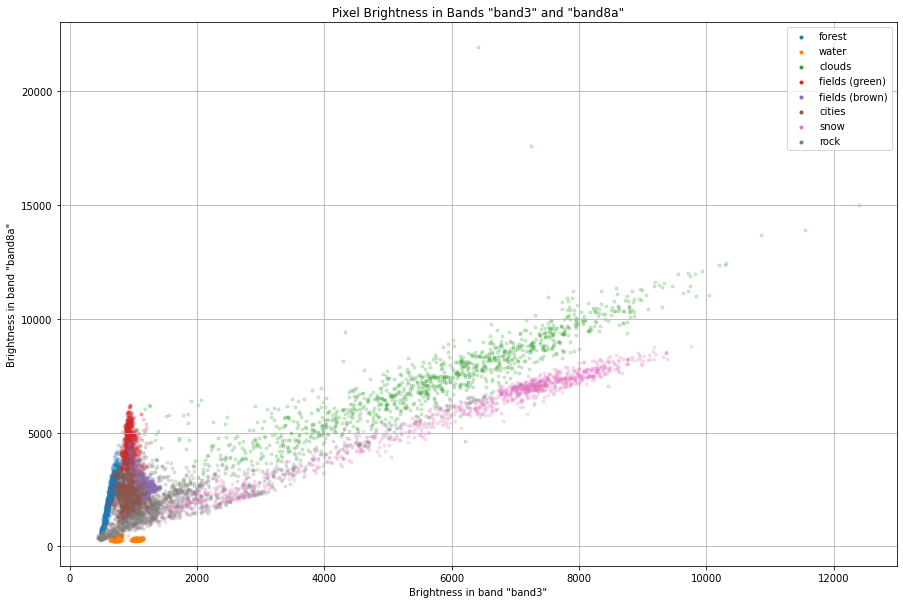

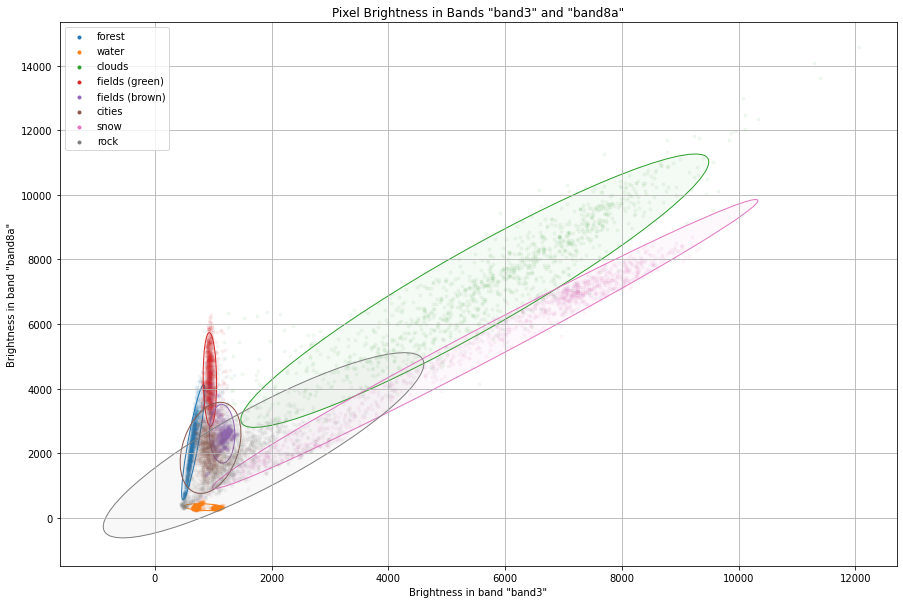

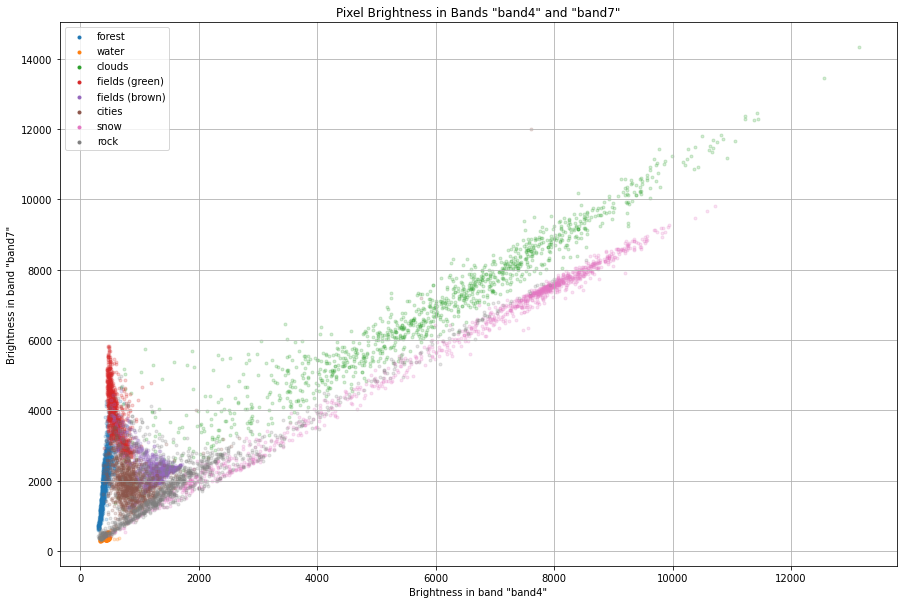

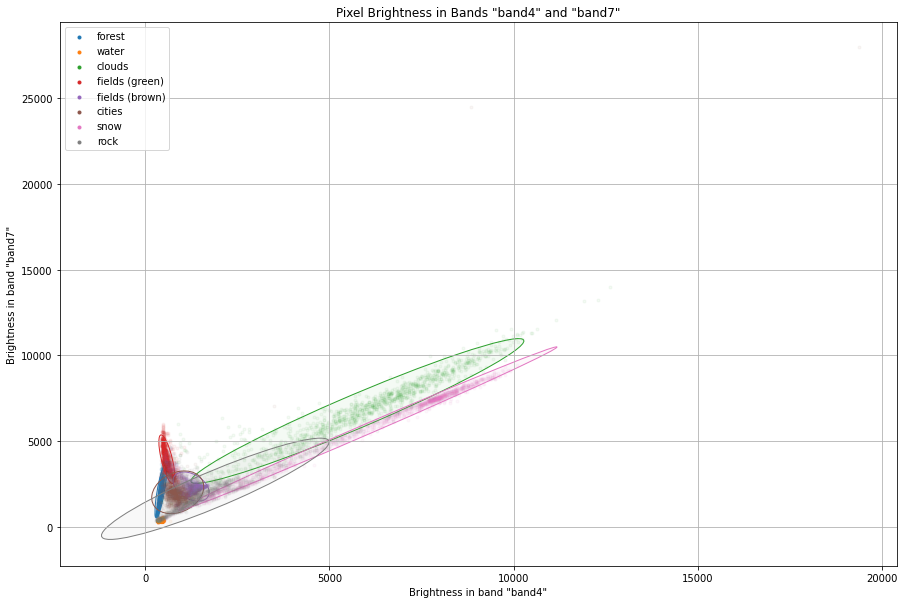

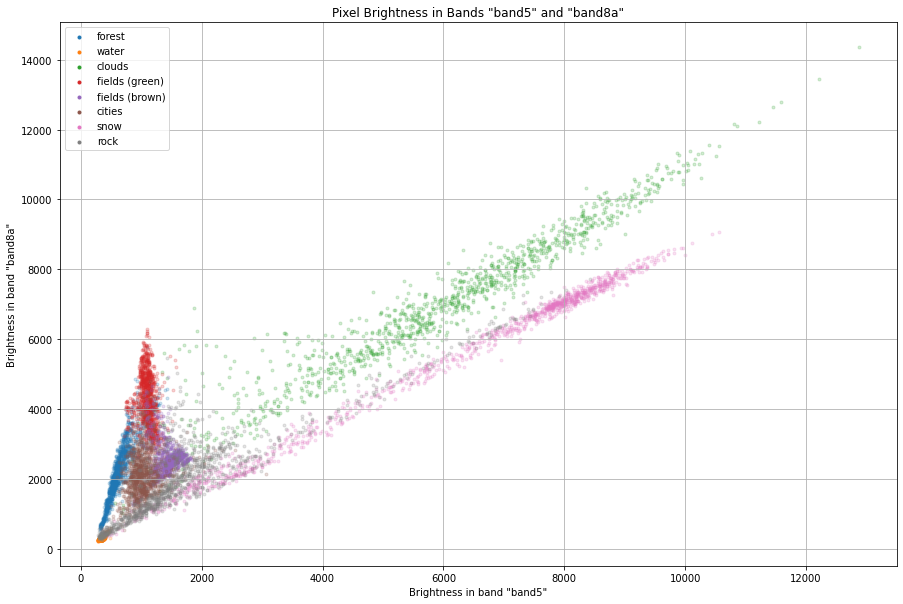

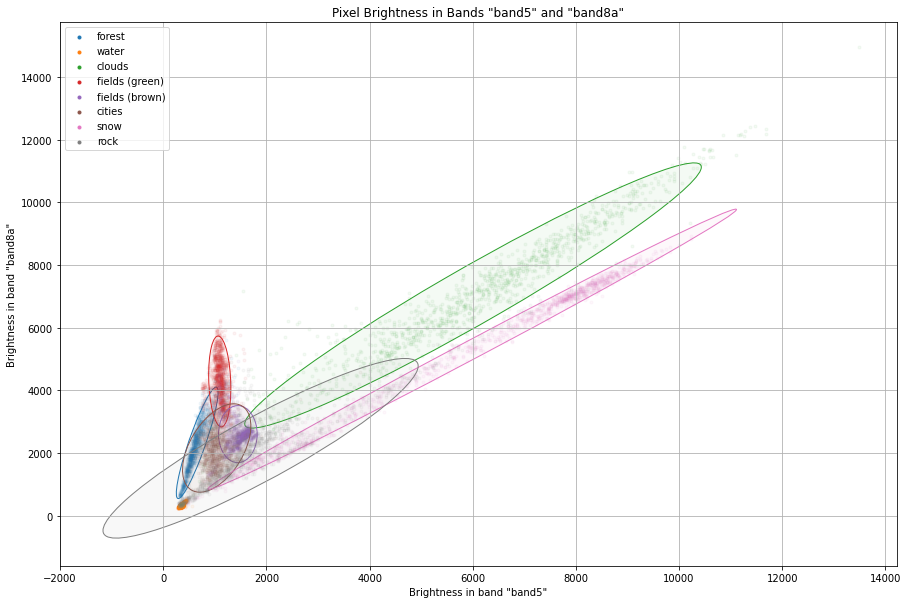

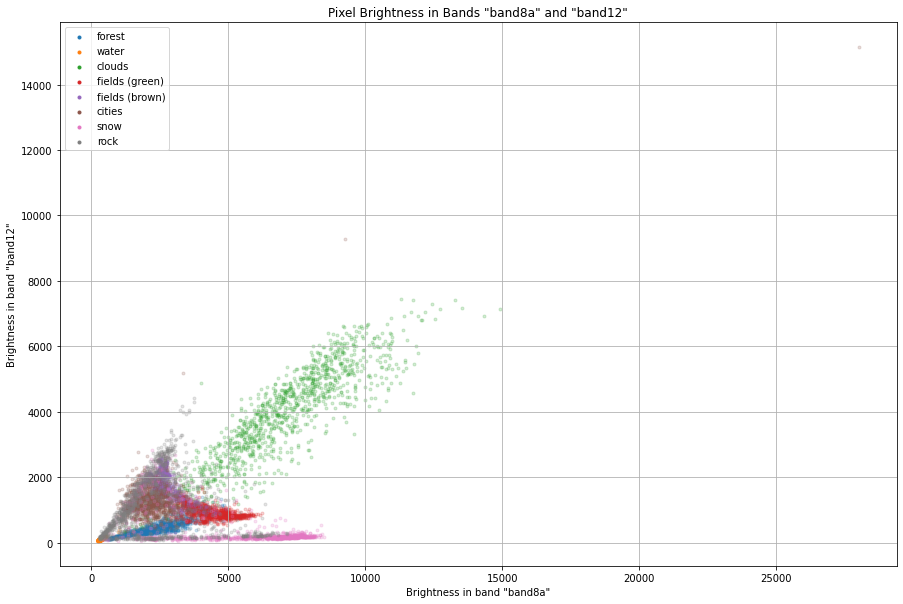

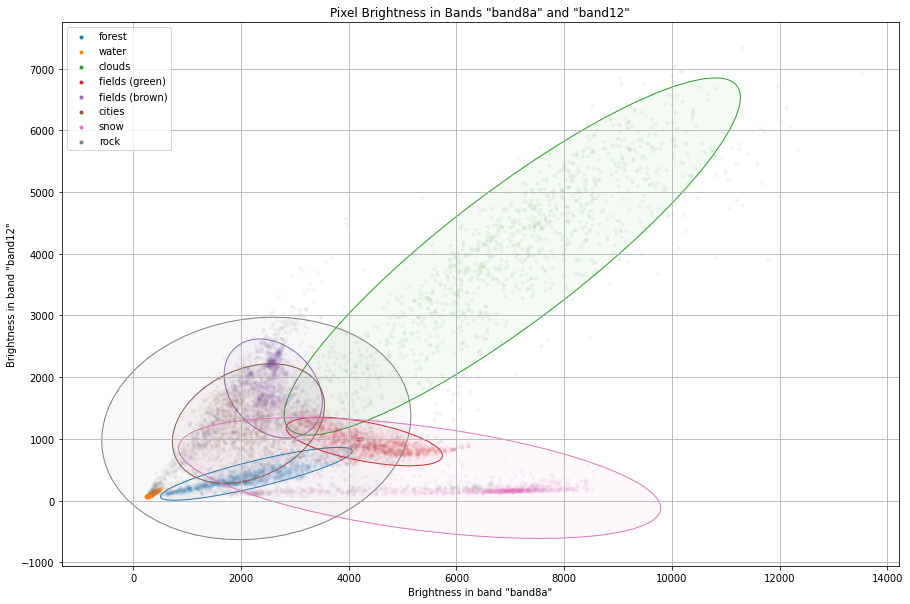

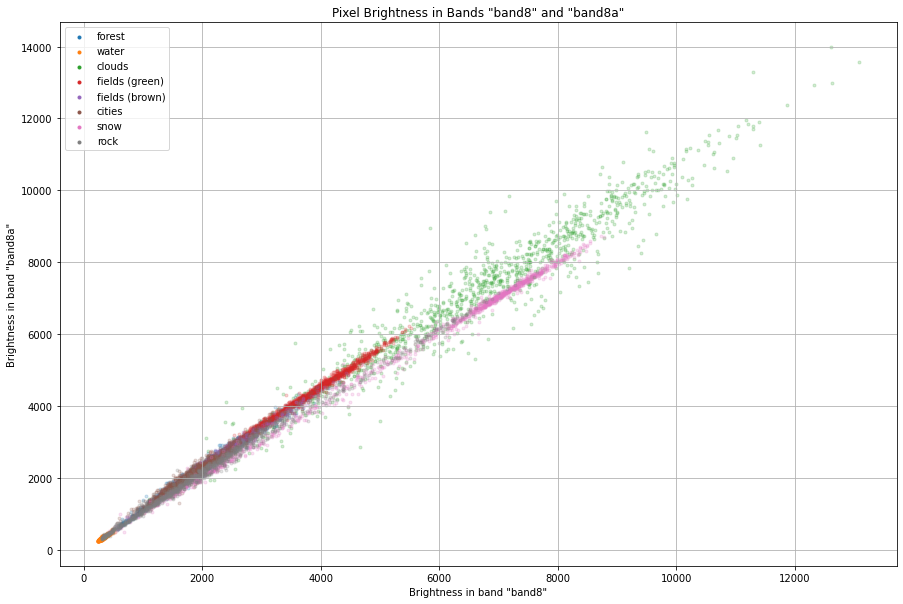

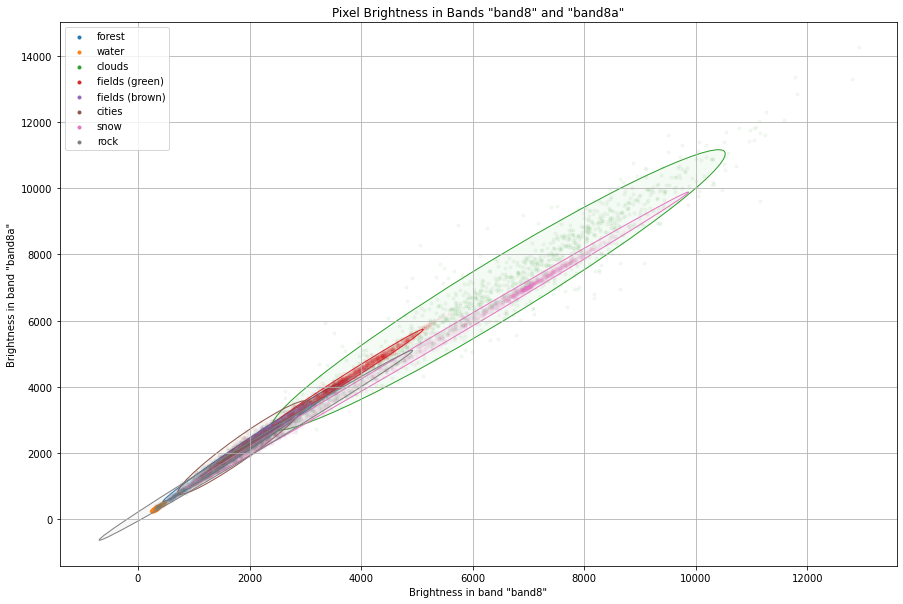

In [13]:
band_x = 'band2'
band_y = 'band8a'

band_combinations = [(1, 7), (2, 5), (3, 7), (7, 9), (6, 8), ]
for x, y in band_combinations:
    band_x, band_y = band_names[x], band_names[y]
    visualiza_bands(band_x, band_y)
    print(band_x, band_y)

In [8]:
band_names

['band2',
 'band3',
 'band4',
 'band5',
 'band6',
 'band7',
 'band8',
 'band8a',
 'band11',
 'band12']